In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [22]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.p = self.m*self.v
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 10.
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        
        self.r += self.dt*self.v
        self.v += self.dt*self.a
        
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]

In [38]:
def GetParticles(N,t):
    
    r0 = np.array([-5,0.5])
    v0 = np.array([10.,0])
    a0 = np.array([0.,0.])
    
    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)
    
    Particles = [p0]
    
    return Particles

In [39]:
dt = 0.01
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [40]:
def RunSimulation(t,Particles):
    
    for it in range(len(t)):
        
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            
    return Particles

In [41]:
Particles = RunSimulation(t,Particles)

In [42]:
Particles[0].GetPosition()

array([[-5. ,  0.5],
       [-4.9,  0.5],
       [-4.8,  0.5],
       ...,
       [94.7,  0.5],
       [94.8,  0.5],
       [94.9,  0.5]])

<IPython.core.display.Javascript object>


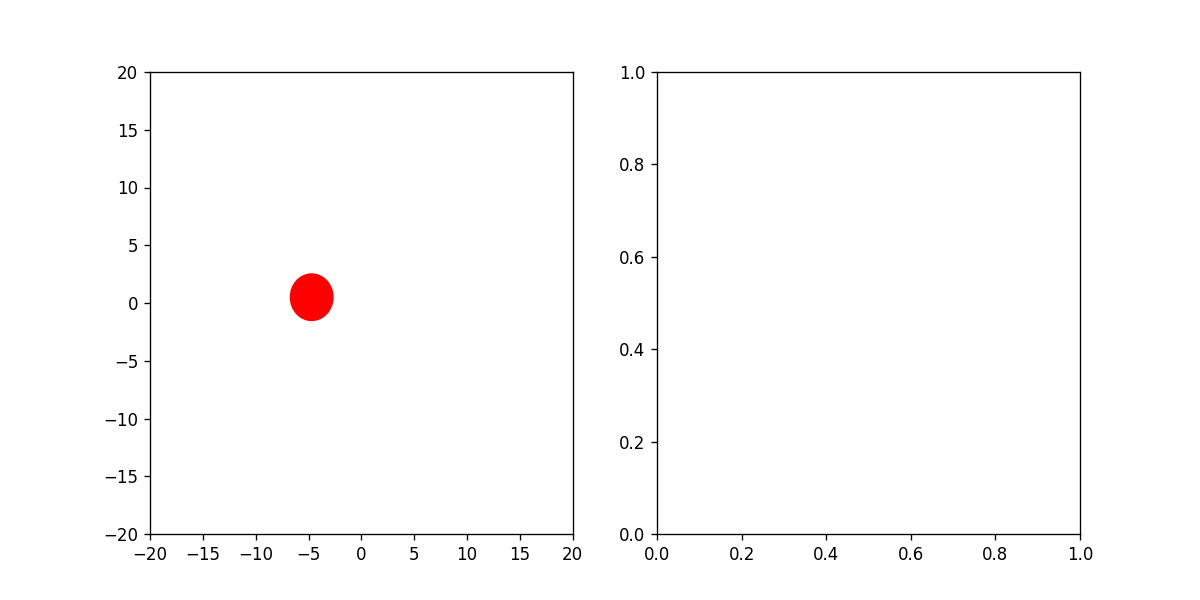

In [43]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    
    for p in Particles:
        
        x = p.GetPosition()[i,0]
        y = p.GetPosition()[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=True )
        ax.add_patch(circle)
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t),init_func=init)